In [1]:
from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
import sklearn
import xgboost.sklearn
from xgboost.spark import SparkXGBClassifier

In [ ]:
import os, pathlib, shutil, sys
os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["PATH"]       = r"C:\hadoop\bin;" + os.environ["PATH"]
os.environ["AWS_PROFILE"] = "ryanj"
os.environ["AWS_REGION"]  = "us-west-2"
os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["PATH"] = rf'{os.environ["HADOOP_HOME"]}\bin;' + os.environ["PATH"]
os.environ["AWS_ACCESS_KEY_ID"] = ""
os.environ["AWS_SECRET_ACCESS_KEY"] = ""
os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages org.apache.hadoop:hadoop-aws:3.3.4 "
    "--conf spark.hadoop.fs.s3a.impl=org.apache.hadoop.fs.s3a.S3AFileSystem "
    "--conf spark.hadoop.fs.s3a.aws.region=us-west-2 "
    "--conf spark.hadoop.fs.s3a.aws.credentials.provider=com.amazonaws.auth.DefaultAWSCredentialsProviderChain "
    "--conf spark.hadoop.io.native.lib.available=false "
    "--conf spark.hadoop.fs.s3a.fast.upload=true "
    "--conf spark.hadoop.fs.s3a.fast.upload.buffer=bytebuffer "
    "pyspark-shell"
)

In [3]:
spark = (SparkSession.builder
         .appName("sumo-s3a")
         .config(
            "spark.jars.packages",
            "org.xgboost:xgboost4j_2.12:2.0.3,"
            "org.xgboost:xgboost4j-spark_2.12:2.0.3,"
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.262"
         )
         # make sure S3A is wired up; you can keep these if they helped earlier
         .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
         .config("spark.hadoop.fs.s3a.aws.credentials.provider", "com.amazonaws.auth.profile.ProfileCredentialsProvider")
         .config("spark.hadoop.fs.s3a.aws.region", "us-west-2")
         .config("spark.driver.memory", "4g")
         .config("spark.executor.memory", "4g")
         .config("spark.pyspark.python", sys.executable)          # workers use venv python
         .config("spark.pyspark.driver.python", sys.executable)   # driver uses venv python
         .config("spark.network.timeout", "600s")
         .config("spark.executor.heartbeatInterval", "60s")
         .config("spark.sql.execution.barrier.enabled", "true")
         
         .getOrCreate())

25/09/30 20:14:39 WARN Utils: Your hostname, DESKTOP-H8JETTE resolves to a loopback address: 127.0.1.1; using 172.31.29.112 instead (on interface eth0)
25/09/30 20:14:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e5062e53-c337-439b-b15e-be20943dba67;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 140ms :: artifacts dl 4ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	-----------------------------------------------

In [4]:
print(spark.sparkContext._jsc.sc().listJars())


Vector(spark://172.31.29.112:38403/jars/com.amazonaws_aws-java-sdk-bundle-1.12.262.jar, spark://172.31.29.112:38403/jars/org.apache.hadoop_hadoop-aws-3.3.4.jar, spark://172.31.29.112:38403/jars/org.wildfly.openssl_wildfly-openssl-1.0.7.Final.jar)


In [5]:
hc = spark.sparkContext._jsc.hadoopConfiguration()
print("S3A impl:", hc.get("fs.s3a.impl")) 

S3A impl: org.apache.hadoop.fs.s3a.S3AFileSystem


In [6]:
# make a writable local temp dir
spark_local = r"C:\tmp\spark"
pathlib.Path(spark_local).mkdir(parents=True, exist_ok=True)

In [7]:
print("Spark:", spark.version)
print("Hadoop:", spark.sparkContext._jvm.org.apache.hadoop.util.VersionInfo.getVersion())

Spark: 3.5.2
Hadoop: 3.3.4


In [8]:
spark.conf.set("spark.hadoop.fs.s3a.connection.establish.timeout", "30000")   # 30s
spark.conf.set("spark.hadoop.fs.s3a.threads.keepalivetime",        "60000")   # 60s
spark.conf.set("spark.hadoop.fs.s3a.connection.ttl",              "300000")   # 5m
spark.conf.set("spark.hadoop.fs.s3a.retry.interval",                 "500")   # 500ms
spark.conf.set("spark.hadoop.fs.s3a.retry.throttle.interval",        "100")   # 100ms

In [9]:
# convert human-friendly durations to plain integers (milliseconds)
hconf = spark.sparkContext._jsc.hadoopConfiguration()

fixes = {
    "fs.s3a.connection.establish.timeout": "30000",    # 30s
    "fs.s3a.threads.keepalivetime": "60000",           # 60s
    "fs.s3a.retry.interval": "500",                    # 500ms
    "fs.s3a.retry.throttle.interval": "100",           # 100ms
    "fs.s3a.connection.ttl": "300000",                 # 5m
    "fs.s3a.assumed.role.session.duration": "1800000"  # 30m
}
for k, v in fixes.items():
    hconf.set(k, v)

# (optional) double-check one
print("keepalive:", hconf.get("fs.s3a.threads.keepalivetime"))


keepalive: 60000


In [10]:
import re

hconf = spark.sparkContext._jsc.hadoopConfiguration()

# report any time-looking values with units
offenders = []
it = hconf.iterator()
pairs = []
while it.hasNext():
    e = it.next()
    pairs.append((e.getKey(), e.getValue()))

r_time = re.compile(r"^\s*\d+\s*(ms|s|m|h|d)\s*$", re.I)

for k, v in pairs:
    if r_time.match(str(v)):
        offenders.append((k, v))

print("Offenders before fix:")
for k, v in offenders:
    print(f"  {k} = {v}")

# convert unit-suffixed durations to milliseconds
UNIT_MS = {"ms":1, "s":1000, "m":60_000, "h":3_600_000, "d":86_400_000}

def to_ms_str(val):
    m = re.fullmatch(r"\s*(\d+)\s*(ms|s|m|h|d)\s*", str(val).lower())
    if not m: 
        return None
    n = int(m.group(1)); u = m.group(2)
    return str(n * UNIT_MS[u])

changed = []
for k, v in pairs:
    ms = to_ms_str(v)
    if ms and ms != v:
        hconf.set(k, ms)
        changed.append((k, v, ms))

print("\nNormalized to milliseconds:")
for k, old, new in changed:
    print(f"  {k}: {old} -> {new}")

# show any stragglers still using units
left = []
it = hconf.iterator()
while it.hasNext():
    e = it.next()
    if r_time.match(str(e.getValue())):
        left.append((e.getKey(), e.getValue()))
print("\nRemaining with units (should be empty):", left)


Offenders before fix:
  fs.s3a.s3guard.consistency.retry.interval = 2s
  fs.s3a.s3guard.ddb.background.sleep = 25ms
  fs.s3a.s3guard.ddb.throttle.retry.interval = 100ms
  fs.s3a.metadatastore.metadata.ttl = 15m
  hadoop.security.groups.shell.command.timeout = 0s
  hadoop.service.shutdown.timeout = 30s
  fs.s3a.multipart.threshold = 128M
  yarn.resourcemanager.delegation-token-renewer.thread-retry-interval = 60s
  fs.s3a.block.size = 32M
  fs.s3a.multipart.size = 64M
  fs.azure.sas.expiry.period = 90d
  yarn.resourcemanager.delegation-token-renewer.thread-timeout = 60s

Normalized to milliseconds:
  fs.s3a.s3guard.consistency.retry.interval: 2s -> 2000
  fs.s3a.s3guard.ddb.background.sleep: 25ms -> 25
  fs.s3a.s3guard.ddb.throttle.retry.interval: 100ms -> 100
  fs.s3a.metadatastore.metadata.ttl: 15m -> 900000
  hadoop.security.groups.shell.command.timeout: 0s -> 0
  hadoop.service.shutdown.timeout: 30s -> 30000
  fs.s3a.multipart.threshold: 128M -> 7680000
  yarn.resourcemanager.delegat

In [11]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")  # avoids choking on stray files

# bronze reads and silver writes

In [10]:


df = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.json")         # only JSON files
      .json("s3a://ryans-sumo-bucket/sumo-api-calls/rikishi_matches/"))


In [11]:

# After your JSON read
df.printSchema()
# You'll likely see: root
#  |-- 0: array (nullable = true)
#  |    |-- element: struct (contains your fields)

rows = df.select(explode(col("records")).alias("match"))
flat = rows.select("match.*")   # expand struct into columns
flat.show(20, truncate=False)
flat.printSchema()

root
 |-- limit: long (nullable = true)
 |-- records: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- bashoId: string (nullable = true)
 |    |    |-- day: long (nullable = true)
 |    |    |-- division: string (nullable = true)
 |    |    |-- eastId: long (nullable = true)
 |    |    |-- eastRank: string (nullable = true)
 |    |    |-- eastShikona: string (nullable = true)
 |    |    |-- kimarite: string (nullable = true)
 |    |    |-- matchNo: long (nullable = true)
 |    |    |-- westId: long (nullable = true)
 |    |    |-- westRank: string (nullable = true)
 |    |    |-- westShikona: string (nullable = true)
 |    |    |-- winnerEn: string (nullable = true)
 |    |    |-- winnerId: long (nullable = true)
 |    |    |-- winnerJp: string (nullable = true)
 |-- skip: long (nullable = true)
 |-- total: long (nullable = true)

+-------+---+--------+------+------------------+-----------+-----------+-------+------+------------------+-----------+-

convert to parquet

In [12]:
silver = (flat
          .dropDuplicates())          # typical dedupe key

In [13]:
silver = (silver
         .withColumn("year", F.col("bashoId").cast("string").substr(1,4))
          .withColumn("month", F.col("bashoId").cast("string").substr(5,2))
          .withColumn("match_date",
                     F.to_date(
                         F.concat_ws("-", F.col("year"), F.col("month"), F.lpad(F.col("day"), 2, "0")),
                             "yyyy-MM-dd"
                         )
                     )
          .withColumn(
              "match_id",
              F.concat_ws("", F.date_format(F.col("match_date"), "yyyyMMdd"), F.col("matchNo").cast("string")).cast("long")
          )
          .drop("year", "month")
         )

In [14]:
silver.show(10)

+-------+---+--------+------+------------------+-----------+-----------+-------+------+------------------+-----------+-----------+--------+--------+----------+----------+
|bashoId|day|division|eastId|          eastRank|eastShikona|   kimarite|matchNo|westId|          westRank|westShikona|   winnerEn|winnerId|winnerJp|match_date|  match_id|
+-------+---+--------+------+------------------+-----------+-----------+-------+------+------------------+-----------+-----------+--------+--------+----------+----------+
| 201501|  1|Makuuchi|  3835| Maegashira 7 East| Kyokutenho|   yorikiri|     10|   670| Maegashira 7 West| Chiyootori| Kyokutenho|    3835|        |2015-01-01|2015010110|
| 201407| 15|Makuuchi|  3835|Maegashira 12 East| Kyokutenho|   yorikiri|      2|  4126|Maegashira 15 West|  Tokitenku|  Tokitenku|    4126|        |2014-07-15| 201407152|
| 201309| 10|Makuuchi|  4177|Maegashira 13 West|    Homasho|   yorikiri|     10|  3835| Maegashira 6 West| Kyokutenho|    Homasho|    4177|      

In [15]:
# optional sanity checks:
hc = spark.sparkContext._jsc.hadoopConfiguration()
print("io.native.lib.available =", hc.get("io.native.lib.available"))
print("fs.s3a.fast.upload =", hc.get("fs.s3a.fast.upload"))
print("fs.s3a.fast.upload.buffer =", hc.get("fs.s3a.fast.upload.buffer"))

io.native.lib.available = false
fs.s3a.fast.upload = true
fs.s3a.fast.upload.buffer = bytebuffer


In [16]:
(silver.write
 .mode("overwrite")
 .option("compression", "snappy")
 .partitionBy("bashoId")                        # or by year/month/day
 .parquet("s3a://ryans-sumo-bucket/silver/rikishi_matches/"))

In [28]:
df = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.json")         # only JSON files
      .json("s3a://ryans-sumo-bucket/sumo-api-calls/rikishis/"))

In [30]:
df.show(10)

+--------------------+-----------------+------+------+-----------+----+--------------------+-----+--------------------+----------------------+--------------------+--------+------+
|           birthDate|      currentRank| debut|height|       heya|  id|               intai|nskId|           shikonaEn|             shikonaJp|            shusshin|sumodbId|weight|
+--------------------+-----------------+------+------+-----------+----+--------------------+-----+--------------------+----------------------+--------------------+--------+------+
|1975-08-22T00:00:00Z|             NULL|199103| 187.5|   Kasugano|3739|2011-01-01T00:00:00Z|    0|Kasuganishiki Tak...|                  NULL|Chiba-ken, Isumi-...|     107| 146.3|
|2000-10-21T00:00:00Z|   Jonidan 3 East|201903| 176.0|Shikoroyama| 279|2025-03-26T00:00:00Z| 3959|           Kawabuchi|        川渕(かわぶち)|Ishikawa-ken, Kan...|   12568| 118.0|
|1977-04-15T00:00:00Z| Jonidan 100 West|199601| 170.3|  Isegahama| 460|2025-05-28T00:00:00Z| 1407|        

In [31]:
(df.write
 .mode("overwrite")
 .option("compression", "snappy")
 .parquet("s3a://ryans-sumo-bucket/silver/rikishis/"))

In [32]:
df = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.json")         # only JSON files
      .json("s3a://ryans-sumo-bucket/sumo-api-calls/rikishi_stats/"))

df = df.withColumn(
    "rikishi_id",
    F.regexp_extract(F.input_file_name(), r"rikishi_(\d+)\.json", 1)
)

(df.write
 .mode("overwrite")
 .option("compression", "snappy")
 .parquet("s3a://ryans-sumo-bucket/silver/rikishi_stats/"))

In [33]:
df = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.json")         # only JSON files
      .json("s3a://ryans-sumo-bucket/sumo-api-calls/basho/"))
(df.write
 .mode("overwrite")
 .option("compression", "snappy")
 .partitionBy("location")
 .parquet("s3a://ryans-sumo-bucket/silver/bashos/"))

# silvers have been written

In [11]:
df = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.parquet")         # only JSON files
      .parquet("s3a://ryans-sumo-bucket/silver/rikishi_matches/"))

In [12]:
df.show(10)

+---+---------+------+------------------+--------------+-----------+-------+------+------------------+-----------+-----------+--------+--------+----------+----------+
|day| division|eastId|          eastRank|   eastShikona|   kimarite|matchNo|westId|          westRank|westShikona|   winnerEn|winnerId|winnerJp|match_date|  match_id|
+---+---------+------+------------------+--------------+-----------+-------+------+------------------+-----------+-----------+--------+--------+----------+----------+
|  8| Makuuchi|   794| Maegashira 3 East|         Terao|   yorikiri|     14|  4071|   Sekiwake 1 West|       Kaio|       Kaio|    4071|        |1996-05-08|1996050814|
|  4|Makushita|  3827| Makushita 17 East|   Chiyotenzan|shitatenage|     24|  3837| Makushita 15 East| Kitazakura|Chiyotenzan|    3827|        |1996-05-04|1996050424|
|  3|    Juryo|  3835|      Juryo 7 West|    Kyokutenho|   yorikiri|     12|  5078|      Juryo 1 West|Tokitsunada| Kyokutenho|    3835|        |1996-05-03|1996050312

In [13]:
df.count()

738480

In [104]:
matches = (df
      .withColumn(
        "westWin",
        F.when(F.col("winnerId") == F.col("westId"), F.lit(1)).otherwise(F.lit(0))
        )
     )

In [15]:
rikishis = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.parquet")         # only JSON files
      .parquet("s3a://ryans-sumo-bucket/silver/rikishis/"))

rikishi_stats = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.parquet")         # only JSON files
      .parquet("s3a://ryans-sumo-bucket/silver/rikishi_stats/"))


bashos = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.parquet")         # only JSON files
      .parquet("s3a://ryans-sumo-bucket/silver/bashos/"))

In [16]:
matches.show(10)

+---+---------+------+------------------+--------------+-----------+-------+------+------------------+-----------+-----------+--------+--------+----------+----------+-------+
|day| division|eastId|          eastRank|   eastShikona|   kimarite|matchNo|westId|          westRank|westShikona|   winnerEn|winnerId|winnerJp|match_date|  match_id|westWin|
+---+---------+------+------------------+--------------+-----------+-------+------+------------------+-----------+-----------+--------+--------+----------+----------+-------+
|  8| Makuuchi|   794| Maegashira 3 East|         Terao|   yorikiri|     14|  4071|   Sekiwake 1 West|       Kaio|       Kaio|    4071|        |1996-05-08|1996050814|      1|
|  4|Makushita|  3827| Makushita 17 East|   Chiyotenzan|shitatenage|     24|  3837| Makushita 15 East| Kitazakura|Chiyotenzan|    3827|        |1996-05-04|1996050424|      0|
|  3|    Juryo|  3835|      Juryo 7 West|    Kyokutenho|   yorikiri|     12|  5078|      Juryo 1 West|Tokitsunada| Kyokutenho

In [17]:
rikishis.show(10)

+--------------------+-----------------+------+------+-----------+----+--------------------+-----+--------------------+----------------------+--------------------+--------+------+
|           birthDate|      currentRank| debut|height|       heya|  id|               intai|nskId|           shikonaEn|             shikonaJp|            shusshin|sumodbId|weight|
+--------------------+-----------------+------+------+-----------+----+--------------------+-----+--------------------+----------------------+--------------------+--------+------+
|1975-08-22T00:00:00Z|             NULL|199103| 187.5|   Kasugano|3739|2011-01-01T00:00:00Z|    0|Kasuganishiki Tak...|                  NULL|Chiba-ken, Isumi-...|     107| 146.3|
|2000-10-21T00:00:00Z|   Jonidan 3 East|201903| 176.0|Shikoroyama| 279|2025-03-26T00:00:00Z| 3959|           Kawabuchi|        川渕(かわぶち)|Ishikawa-ken, Kan...|   12568| 118.0|
|1977-04-15T00:00:00Z| Jonidan 100 West|199601| 170.3|  Isegahama| 460|2025-05-28T00:00:00Z| 1407|        

In [20]:
bashos.printSchema()

root
 |-- date: string (nullable = true)
 |-- endDate: string (nullable = true)
 |-- specialPrizes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- rikishiId: long (nullable = true)
 |    |    |-- shikonaEn: string (nullable = true)
 |    |    |-- shikonaJp: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- startDate: string (nullable = true)
 |-- yusho: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- rikishiId: long (nullable = true)
 |    |    |-- shikonaEn: string (nullable = true)
 |    |    |-- shikonaJp: string (nullable = true)
 |    |    |-- type: string (nullable = true)



In [21]:
# Rename `date` → `bashoId`, and keep start/end date
base = bashos.select(
    col("date").alias("bashoId"),
    col("startDate"),
    col("endDate")
)

yusho_flat = (
    bashos.withColumn("y", explode(col("yusho")))
      .select(
          col("date").alias("bashoId"),
          col("y.type").alias("yusho_type"),
          col("y.rikishiId").alias("rikishiId")
      )
)

# Pivot so each yusho_type becomes its own column
yusho_pivot = (
    yusho_flat.groupBy("bashoId")
              .pivot("yusho_type")
              .agg(collect_list("rikishiId"))
              .withColumnRenamed("Makuuchi", "Makuuchi_yusho")
              .withColumnRenamed("Juryo", "Juryo_yusho")
)
prizes_flat = (
    bashos.withColumn("p", explode(col("specialPrizes")))
      .select(
          col("date").alias("bashoId"),
          col("p.type").alias("prize_type"),
          col("p.rikishiId").alias("rikishiId")
      )
)


prizes_pivot = (
    prizes_flat.groupBy("bashoId")
               .pivot("prize_type")
               .agg(collect_list("rikishiId"))   # array of rikishiIds
               .withColumnRenamed("Shukun-sho", "Shukun_sho")
               .withColumnRenamed("Kanto-sho", "Kanto_sho")
               .withColumnRenamed("Gino-sho", "Gino_sho")
)
result = (base
          .join(yusho_pivot, on="bashoId", how="left")
          .join(prizes_pivot, on="bashoId", how="left"))

In [22]:
result.show(10)

+-------+--------------------+--------------------+-------+---------+-----------+---------+--------------+--------+------------+-------------+------------+
|bashoId|           startDate|             endDate|Jonidan|Jonokuchi|Juryo_yusho|Makushita|Makuuchi_yusho|Sandanme|    Gino_sho|    Kanto_sho|  Shukun_sho|
+-------+--------------------+--------------------+-------+---------+-----------+---------+--------------+--------+------------+-------------+------------+
| 202501|2025-01-12T00:00:00Z|2025-01-26T00:00:00Z|  [106]|    [159]|       [86]|     [91]|          [19]|  [8869]|        [41]|      [7, 50]|          []|
| 202305|2023-05-14T00:00:00Z|2023-05-28T00:00:00Z|  [609]|   [8862]|       [56]|    [110]|          [45]|   [219]|     [13, 7]|           []|        [38]|
| 201801|2018-01-14T00:00:00Z|2018-01-28T00:00:00Z|  [336]|     [81]|       [36]|     [12]|          [43]|    [69]|        [43]|     [15, 22]|        [43]|
| 201705|2017-05-14T00:00:00Z|2017-05-28T00:00:00Z|  [354]|     

In [23]:
result.printSchema()

root
 |-- bashoId: string (nullable = true)
 |-- startDate: string (nullable = true)
 |-- endDate: string (nullable = true)
 |-- Jonidan: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Jonokuchi: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Juryo_yusho: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Makushita: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Makuuchi_yusho: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Sandanme: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Gino_sho: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Kanto_sho: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- Shukun_sho: array (nullable = true)
 |    |-- element: long (containsNull = false)



In [24]:
rikishi_stats.printSchema()

root
 |-- absenceByDivision: struct (nullable = true)
 |    |-- Jonidan: long (nullable = true)
 |    |-- Jonokuchi: long (nullable = true)
 |    |-- Juryo: long (nullable = true)
 |    |-- Makushita: long (nullable = true)
 |    |-- Makuuchi: long (nullable = true)
 |    |-- Sandanme: long (nullable = true)
 |-- basho: long (nullable = true)
 |-- bashoByDivision: struct (nullable = true)
 |    |-- Jonidan: long (nullable = true)
 |    |-- Jonokuchi: long (nullable = true)
 |    |-- Juryo: long (nullable = true)
 |    |-- Makushita: long (nullable = true)
 |    |-- Makuuchi: long (nullable = true)
 |    |-- Sandanme: long (nullable = true)
 |-- lossByDivision: struct (nullable = true)
 |    |-- Jonidan: long (nullable = true)
 |    |-- Jonokuchi: long (nullable = true)
 |    |-- Juryo: long (nullable = true)
 |    |-- Makushita: long (nullable = true)
 |    |-- Makuuchi: long (nullable = true)
 |    |-- Sandanme: long (nullable = true)
 |-- sansho: struct (nullable = true)
 |    |-- Gi

In [25]:
rikishi_stats = rikishi_stats.select(
    col("rikishi_id"),
    col("yusho"),
    col("yushoByDivision.Makuuchi").alias("makuuchi_yusho"),
    col("totalWins"),
    col("totalLosses"),
    col("totalMatches"),
    col("winsByDivision.Makuuchi").alias("makuuchiWins"),
    col("basho"),
    col("bashoByDivision.Makuuchi").alias("Makuuchi_basho"),
    col("sansho.Gino-sho").alias("Gino_sho"),
    col("sansho.Kanto-sho").alias("Kanto_sho"),
    col("sansho.Shukun-sho").alias("Shukun_sho")
)

In [26]:
rikishi_stats.show(10)

+----------+-----+--------------+---------+-----------+------------+------------+-----+--------------+--------+---------+----------+
|rikishi_id|yusho|makuuchi_yusho|totalWins|totalLosses|totalMatches|makuuchiWins|basho|Makuuchi_basho|Gino_sho|Kanto_sho|Shukun_sho|
+----------+-----+--------------+---------+-----------+------------+------------+-----+--------------+--------+---------+----------+
|        35|    3|          NULL|      753|        765|        1518|         405|  132|            58|    NULL|        3|      NULL|
|        44|    1|          NULL|      787|        593|        1380|         627|  120|            84|       3|        6|         4|
|      5306|    4|          NULL|      457|        433|         890|         164|  100|            26|    NULL|        1|      NULL|
|        16|    2|          NULL|      635|        648|        1283|         289|  114|            43|    NULL|        1|         1|
|       794|    2|          NULL|      858|        937|        1795| 

In [105]:
main = matches

In [31]:
rikishis = (rikishis
       .join(rikishi_stats, rikishis.id == rikishi_stats.rikishi_id, how = "left"))

In [32]:
rikishis.show(10)

+--------------------+-----------------+------+------+-----------+----+--------------------+-----+--------------------+----------------------+--------------------+--------+------+----------+-----+--------------+---------+-----------+------------+------------+-----+--------------+--------+---------+----------+
|           birthDate|      currentRank| debut|height|       heya|  id|               intai|nskId|           shikonaEn|             shikonaJp|            shusshin|sumodbId|weight|rikishi_id|yusho|makuuchi_yusho|totalWins|totalLosses|totalMatches|makuuchiWins|basho|Makuuchi_basho|Gino_sho|Kanto_sho|Shukun_sho|
+--------------------+-----------------+------+------+-----------+----+--------------------+-----+--------------------+----------------------+--------------------+--------+------+----------+-----+--------------+---------+-----------+------------+------------+-----+--------------+--------+---------+----------+
|1975-08-22T00:00:00Z|             NULL|199103| 187.5|   Kasugano|3

In [36]:
rikishis.printSchema()

root
 |-- birthDate: string (nullable = true)
 |-- currentRank: string (nullable = true)
 |-- debut: string (nullable = true)
 |-- height: double (nullable = true)
 |-- id: long (nullable = true)
 |-- intai: string (nullable = true)
 |-- weight: double (nullable = true)
 |-- rikishi_id: string (nullable = true)
 |-- yusho: long (nullable = true)
 |-- makuuchi_yusho: long (nullable = true)
 |-- totalWins: long (nullable = true)
 |-- totalLosses: long (nullable = true)
 |-- totalMatches: long (nullable = true)
 |-- makuuchiWins: long (nullable = true)
 |-- basho: long (nullable = true)
 |-- Makuuchi_basho: long (nullable = true)
 |-- Gino_sho: long (nullable = true)
 |-- Kanto_sho: long (nullable = true)
 |-- Shukun_sho: long (nullable = true)



In [35]:
rikishis = (rikishis
           .drop("shikonaEn")
            .drop("shikonaJp")
            .drop("sumodbId")
            .drop("nskId")
            .drop("shusshin")
            .drop("heya")
           )

In [146]:
def add_prefix(df, prefix):
    return df.select([F.col(c).alias(f"{prefix}_{c}") for c in df.columns])

# Add prefixes
west = add_prefix(rikishis, "west")
east = add_prefix(rikishis, "east")

# Join with prefixed columns
main = (
    matches
    .join(west, matches.westId == west.west_id, "left")
    .join(east, matches.eastId == east.east_id, "left")
)
main.printSchema()

root
 |-- day: long (nullable = true)
 |-- division: string (nullable = true)
 |-- eastId: long (nullable = true)
 |-- eastRank: string (nullable = true)
 |-- eastShikona: string (nullable = true)
 |-- kimarite: string (nullable = true)
 |-- matchNo: long (nullable = true)
 |-- westId: long (nullable = true)
 |-- westRank: string (nullable = true)
 |-- westShikona: string (nullable = true)
 |-- winnerEn: string (nullable = true)
 |-- winnerId: long (nullable = true)
 |-- winnerJp: string (nullable = true)
 |-- match_date: date (nullable = true)
 |-- match_id: long (nullable = true)
 |-- westWin: integer (nullable = false)
 |-- west_birthDate: string (nullable = true)
 |-- west_currentRank: string (nullable = true)
 |-- west_debut: string (nullable = true)
 |-- west_height: double (nullable = true)
 |-- west_id: long (nullable = true)
 |-- west_intai: string (nullable = true)
 |-- west_weight: double (nullable = true)
 |-- west_rikishi_id: string (nullable = true)
 |-- west_yusho: long 

In [43]:
ranks = (spark.read
      .option("multiLine", "true")                # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .option("pathGlobFilter", "*.json")         # only JSON files
      .json("s3a://ryans-sumo-bucket/sumo-api-calls/rikishi_ranks/"))

In [63]:
# explode records and flatten struct fields
rows = ranks.select(explode(col("records")).alias("rank"))
flat = rows.select("rank.*")   # expand struct into columns
ranks = (flat.select("rank", "rankValue").dropDuplicates())

In [ ]:

# Filter out empty ranks
filtered = ranks.filter(F.col("rank") != "")

# Add a flag: east = 0 (better), west = 1 (worse)
with_side = filtered.withColumn(
    "side_flag",
    F.when(F.col("rank").like("%East"), F.lit(0))
     .when(F.col("rank").like("%West"), F.lit(1))
     .otherwise(F.lit(2))  # fallback if no side is present
)

# Window: order by rankValue asc, then side_flag asc
w = Window.orderBy("rankValue", "side_flag")

# Assign sequential ordering
ordered_ranks = (
    with_side
    .withColumn("order", F.row_number().over(w))
    .select("rank", "rankValue", "order")
)


In [65]:
ordered_ranks.show(20)

+-----------------+---------+-----+
|             rank|rankValue|order|
+-----------------+---------+-----+
|  Yokozuna 1 East|      101|    1|
|  Yokozuna 1 West|      101|    2|
|  Yokozuna 2 East|      102|    3|
|  Yokozuna 2 West|      102|    4|
|     Ozeki 1 East|      201|    5|
|     Ozeki 1 West|      201|    6|
|     Ozeki 2 East|      202|    7|
|     Ozeki 2 West|      202|    8|
|     Ozeki 3 East|      203|    9|
|     Ozeki 3 West|      203|   10|
|  Sekiwake 1 East|      301|   11|
|  Sekiwake 1 West|      301|   12|
|  Sekiwake 2 East|      302|   13|
|  Sekiwake 2 West|      302|   14|
|  Sekiwake 3 East|      303|   15|
|  Komusubi 1 East|      401|   16|
|  Komusubi 1 West|      401|   17|
|  Komusubi 2 East|      402|   18|
|  Komusubi 2 West|      402|   19|
|Maegashira 1 East|      501|   20|
+-----------------+---------+-----+
only showing top 20 rows


In [147]:
# Add prefixes
west = add_prefix(ordered_ranks, "west")
east = add_prefix(ordered_ranks, "east")

main = (main
       .join(west, main.westRank == west.west_rank, "left")
       .join(east, main.eastRank == east.east_rank, "left")
       )

In [148]:
# 1️⃣ Create new parsed date columns safely
main = main.withColumn(
    "east_birthdate_parsed",
    F.to_date(F.regexp_replace(F.col("east_birthdate"), "T.*Z", ""), "yyyy-MM-dd")
).withColumn(
    "west_birthdate_parsed",
    F.to_date(F.regexp_replace(F.col("west_birthdate"), "T.*Z", ""), "yyyy-MM-dd")
).withColumn(
    "match_date_parsed",
    F.to_date(F.col("match_date"), "yyyy-MM-dd")
)

# 2️⃣ Drop original ISO 8601 string columns to avoid automatic timestamp parsing
main = main.drop("east_birthdate", "west_birthdate", "match_date")

# 3️⃣ Calculate ages based on parsed dates
main = main.withColumn(
    "east_age",
    F.floor(F.months_between(F.col("match_date_parsed"), F.col("east_birthdate_parsed")) / 12)
).withColumn(
    "west_age",
    F.floor(F.months_between(F.col("match_date_parsed"), F.col("west_birthdate_parsed")) / 12)
)

# ✅ Optional: rename parsed match date to original name if needed
main = main.withColumnRenamed("match_date_parsed", "match_date")

In [149]:
# 1️⃣ Normalize debut strings: handle YYYYMM format
main = main.withColumn(
    "east_debut_clean",
    F.when(F.length("east_debut") == 6,
           F.concat_ws("-", F.col("east_debut").substr(1,4), F.col("east_debut").substr(5,2), F.lit("01"))
          ).otherwise(F.col("east_debut"))
).withColumn(
    "west_debut_clean",
    F.when(F.length("west_debut") == 6,
           F.concat_ws("-", F.col("west_debut").substr(1,4), F.col("west_debut").substr(5,2), F.lit("01"))
          ).otherwise(F.col("west_debut"))
)

# 2️⃣ Strip ISO 8601 T/Z if present and parse to date
main = main.withColumn(
    "east_debut_parsed",
    F.to_date(F.regexp_replace("east_debut_clean", "T.*Z", ""), "yyyy-MM-dd")
).withColumn(
    "west_debut_parsed",
    F.to_date(F.regexp_replace("west_debut_clean", "T.*Z", ""), "yyyy-MM-dd")
)

# 3️⃣ Calculate years active
main = main.withColumn(
    "east_years_active",
    F.floor(F.months_between("match_date", "east_debut_parsed") / 12)
).withColumn(
    "west_years_active",
    F.floor(F.months_between("match_date", "west_debut_parsed") / 12)
)

In [150]:
(ordered_ranks.write
 .mode("overwrite")
 .option("compression", "snappy")
 .parquet("s3a://ryans-sumo-bucket/gold/ordered_ranks/"))

In [151]:
(main.write
 .mode("overwrite")
 .option("compression", "snappy")
 .parquet("s3a://ryans-sumo-bucket/gold/ml_training/"))

In [46]:
main.show(10)

+-------+-----------+-----------+----------+-------------------+--------------+----------------+-----------------+-----------------+----------+-------------------+-------------+--------------+---------------+-----------+-----------+----------+-------------------+--------------+----------------+-----------------+-----------------+----------+-------------------+-------------+--------------+---------------+----------+----------+----------+--------+--------+-----------------+-----------------+
|westWin|west_height|west_weight|west_yusho|west_makuuchi_yusho|west_totalWins|west_totalLosses|west_totalMatches|west_makuuchiWins|west_basho|west_Makuuchi_basho|west_Gino_sho|west_Kanto_sho|west_Shukun_sho|east_height|east_weight|east_yusho|east_makuuchi_yusho|east_totalWins|east_totalLosses|east_totalMatches|east_makuuchiWins|east_basho|east_Makuuchi_basho|east_Gino_sho|east_Kanto_sho|east_Shukun_sho|west_order|east_order|match_date|east_age|west_age|east_years_active|west_years_active|
+-------+-

In [28]:
main.printSchema()

root
 |-- day: long (nullable = true)
 |-- division: string (nullable = true)
 |-- eastId: long (nullable = true)
 |-- eastRank: string (nullable = true)
 |-- eastShikona: string (nullable = true)
 |-- kimarite: string (nullable = true)
 |-- matchNo: long (nullable = true)
 |-- westId: long (nullable = true)
 |-- westRank: string (nullable = true)
 |-- westShikona: string (nullable = true)
 |-- winnerEn: string (nullable = true)
 |-- winnerId: long (nullable = true)
 |-- winnerJp: string (nullable = true)
 |-- match_id: long (nullable = true)
 |-- westWin: integer (nullable = true)
 |-- west_currentRank: string (nullable = true)
 |-- west_debut: string (nullable = true)
 |-- west_height: double (nullable = true)
 |-- west_id: long (nullable = true)
 |-- west_intai: string (nullable = true)
 |-- west_weight: double (nullable = true)
 |-- west_rikishi_id: string (nullable = true)
 |-- west_yusho: long (nullable = true)
 |-- west_makuuchi_yusho: long (nullable = true)
 |-- west_totalWins:

# EDA AND FEATURE ENGINEERING

In [12]:
main = (spark.read              # set to "false" if you have JSON Lines
      .option("mode", "PERMISSIVE")               # or "FAILFAST"
      .option("recursiveFileLookup", "true")
      .parquet("s3a://ryans-sumo-bucket/gold/ml_training/"))

25/09/30 20:14:57 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/09/30 20:14:57 WARN S3AUtils: fs.s3a.multipart.size must be at least 5 MB; configured value is 3840000
                                                                                

In [13]:
main = main.withColumn(
    "match_id",
    concat(
        col("match_id").cast(StringType()),
        col("eastId").cast(StringType()),
        col("westId").cast(StringType())
    )
)

In [14]:
# Add unique match_id for joining back later
main = (
    main
    .withColumn("match_ts", F.col("match_date").cast("timestamp"))
)

# get west_id rows
west_rows = (
    main
    .select(
        "match_id", "match_ts",
        F.col("westId").alias("rikishiId"),
        F.lit("west").alias("side"),
        F.col("westWin").cast("int").alias("isWin")
    )
)

#get east_id rows
east_rows = (
    main
    .select(
        "match_id", "match_ts",
        F.col("eastId").alias("rikishiId"),
        F.lit("east").alias("side"),
        (1 - F.col("westWin").cast("int")).alias("isWin")
    )
)

long_df = (
    west_rows.unionByName(east_rows)
    .withColumn("ts", F.col("match_ts").cast("long"))
)

# Define rolling 6-month window (~183 days)
six_months_sec = 183 * 24 * 3600
# this defines a "window" of rows that we will run our rolling average calculation over so it doesn't run on the whole dataset
w6 = Window.partitionBy("rikishiId").orderBy("ts").rangeBetween(-six_months_sec, 0)

# Rolling win/loss %
rolled_long = (
    long_df
    .withColumn("wins_6m", F.sum("isWin").over(w6))
    .withColumn("games_6m", F.count(F.lit(1)).over(w6))
    #precision 2 using wins_6m and games_6m
    .withColumn("rolling_winloss", F.round(F.col("wins_6m") / F.col("games_6m"), 2))
)

# Pivot back to per match
rolled_wide = (
    rolled_long
    .groupBy("match_id")
    .agg(
        F.first(F.when(F.col("side") == "west", F.col("rolling_winloss")), ignorenulls=True)
          .alias("rolling_winloss_west"),
        F.first(F.when(F.col("side") == "east", F.col("rolling_winloss")), ignorenulls=True)
          .alias("rolling_winloss_east")
    )
)

# Merge back into main
main = (
    main
    .join(rolled_wide, on="match_id", how="left")
    .drop("match_id", "match_ts")
)

In [15]:
main = main.drop('winnerEn', 'winnerJp', 'division', 'day', 'matchNo', 'west_intai', 'east_intai', 'west_rankValue', 'east_rankValue', 'eastRank', 'westRank', 'eastShikona', 'westShikona', 'east_birthdate_parsed', 'west_birthdate_parsed', 'winnerId', 'west_id', 'east_id', 'west_debut', 'east_debut', 'west_debut_parsed', 'east_debut_parsed', 'east_debut_clean', 'west_debut_clean', 'west_rikishi_id', 'east_rikishi_id', 'west_currentRank', 'east_currentRank', 'west_rank', 'east_rank', 'match_date')

In [16]:
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F, Window
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

imputer = Imputer(inputCols = ['west_height', 'west_weight', 'west_age', 'east_height', 'east_weight', 'east_age'], 
                  outputCols = ['west_height', 'west_weight', 'west_age', 'east_height', 'east_weight', 'east_age']
                 ).setStrategy("mean")
main = imputer.fit(main).transform(main)

In [17]:
main = main.replace("", "NA", subset=['kimarite'])

In [18]:
main = main.na.fill(value = main.select(max(col("west_order"))).first()[0], subset=["west_order", "east_order"])

In [19]:
# 2) Safe ratio helper (avoid division by 0)
def safe_ratio(numer, denom, default=F.lit(None)):
    return F.when(denom.isNull() | (denom == 0), default).otherwise(numer / denom)

# 3) Core win-rate features for both sides
main = (
    main
    .withColumn("west_winRate", safe_ratio(F.col("west_totalWins").cast("double"), F.col("west_totalMatches").cast("double")))
    .withColumn("east_winRate", safe_ratio(F.col("east_totalWins").cast("double"), F.col("east_totalMatches").cast("double")))
    .withColumn("west_makuuchiWinRate", safe_ratio(F.col("west_makuuchiWins").cast("double"), F.col("west_Makuuchi_basho").cast("double")))
    .withColumn("east_makuuchiWinRate", safe_ratio(F.col("east_makuuchiWins").cast("double"), F.col("east_Makuuchi_basho").cast("double")))
)

In [20]:
main = (main
        .withColumn("height_difference", F.col("west_height") - F.col("east_height"))
        .withColumn("weight_difference", F.col("west_weight") - F.col("east_weight"))
       )

In [21]:
yotsu_list = [
    "yorikiri","yoritaoshi","uwatenage","shitatenage","uwatedashinage",
    "shitatedashinage","tsuridashi","tsuriotoshi","kimedashi","kimetaoshi",
    "sotogake","uchigake","kakenage","kubinage","kotenage","tottari",
    "uwatehineri","shitatehineri","kainahineri","ashitori","susoharai",
    "susotori"
]

oshi_list = [
    "oshidashi","oshitaoshi","tsukidashi","tsukiotoshi","tsukitaoshi",
    "hatakikomi","hikiotoshi","abisetaoshi","hikkake","okuridashi",
    "okuritaoshi","okurihikiotoshi"
]

In [22]:
def cat_expr(k):
    return (F.when(k.isin(yotsu_list), F.lit("yotsu"))
             .when(k.isin(oshi_list), F.lit("oshi"))
             .otherwise(F.lit("other")))

# 2) Winner-normalized rows; drop NA/unknown kimarite from specialization stats
main_winners = (
    main
    .withColumn("winnerId", F.when(F.col("westWin") == 1, F.col("westId")).otherwise(F.col("eastId")))
    .withColumn("kimarite_norm",
                F.when(F.col("kimarite").isNull() | (F.col("kimarite") == F.lit("NA")), F.lit(None))
                 .otherwise(F.col("kimarite")))
    .filter(F.col("kimarite_norm").isNotNull())
    .withColumn("category", cat_expr(F.col("kimarite_norm")))
)

# 3) Per-rikishi counts & proportions (pivot)
counts = main_winners.groupBy("winnerId","category").count()
pivot = (
    counts.groupBy("winnerId")
          .pivot("category", ["oshi","yotsu","other"])
          .sum("count")
          .na.fill(0)
          .withColumn("total", F.col("oshi")+F.col("yotsu")+F.col("other"))
          .withColumn("oshi_pct",  F.when(F.col("total")>0, F.col("oshi") / F.col("total")).otherwise(F.lit(0.0)))
          .withColumn("yotsu_pct", F.when(F.col("total")>0, F.col("yotsu")/ F.col("total")).otherwise(F.lit(0.0)))
          .withColumn("other_pct", F.when(F.col("total")>0, F.col("other")/ F.col("total")).otherwise(F.lit(0.0)))
)

# 4) Kimarite diversity (Shannon entropy) in pure Spark:
# entropy = -Σ p*ln(p); treat p<=0 as 0 contribution
def entropy_expr(o, y, ot):
    def term(p):  # ln is natural log
        return F.when(p > 0, p * F.log(p)).otherwise(F.lit(0.0))
    return -(term(o) + term(y) + term(ot))

pivot = pivot.withColumn("kimarite_entropy", entropy_expr(F.col("oshi_pct"), F.col("yotsu_pct"), F.col("other_pct")))

# 5) Specialist label (tune thresholds if you’d like)
pivot = pivot.withColumn(
    "specialist",
    F.when(
        (F.col("oshi_pct") > F.col("yotsu_pct")) & (F.col("oshi_pct") > F.col("other_pct")),
        F.lit("oshi")
    ).when(
        (F.col("yotsu_pct") > F.col("oshi_pct")) & (F.col("yotsu_pct") > F.col("other_pct")),
        F.lit("yotsu")
    ).otherwise(F.lit("other"))   # ties or 'other' majority fall here
)

rikishi_profile = pivot.select(
    F.col("winnerId").alias("rikishiId"),
    "specialist",
    "kimarite_entropy",
)

# 6) Join back to main (west/east) and make binary flags
main = (
    main
    .join(
        rikishi_profile.withColumnRenamed("specialist","west_specialist")
                       .withColumnRenamed("kimarite_entropy","west_kimarite_entropy"),
        on=main.westId == F.col("rikishiId"), how="left"
    ).drop("rikishiId")
    .join(
        rikishi_profile.withColumnRenamed("specialist","east_specialist")
                       .withColumnRenamed("kimarite_entropy","east_kimarite_entropy"),
        on=main.eastId == F.col("rikishiId"), how="left"
    ).drop("rikishiId")
    .withColumn("west_specialist_oshi",  (F.col("west_specialist")=="oshi").cast("int"))
    .withColumn("west_specialist_yotsu", (F.col("west_specialist")=="yotsu").cast("int"))
    .withColumn("west_specialist_other", (F.col("west_specialist")=="other").cast("int"))
    .withColumn("east_specialist_oshi",  (F.col("east_specialist")=="oshi").cast("int"))
    .withColumn("east_specialist_yotsu", (F.col("east_specialist")=="yotsu").cast("int"))
    .withColumn("east_specialist_other", (F.col("east_specialist")=="other").cast("int"))
)


In [23]:
west_view = (
    main.select(
        F.col("westId").alias("rikishiId"),
        F.col("east_specialist").alias("opponent_specialist"),
        F.when(F.col("westWin") == 1, 1).otherwise(0).alias("win")
    )
)

east_view = (
    main.select(
        F.col("eastId").alias("rikishiId"),
        F.col("west_specialist").alias("opponent_specialist"),
        F.when(F.col("westWin") == 0, 1).otherwise(0).alias("win")
    )
)

rikishi_vs = west_view.union(east_view)

winrates = (
    rikishi_vs.groupBy("rikishiId", "opponent_specialist")
              .agg(
                  F.count("*").alias("bouts"),
                  F.sum("win").alias("wins")
              )
              .withColumn("winrate", F.when(F.col("bouts") > 0, F.col("wins")/F.col("bouts")).otherwise(F.lit(None)))
)

# 2) Pivot so each rikishi has columns: oshi, yotsu, other (their winrate vs that class)
winrates_pivot = (
    winrates.groupBy("rikishiId")
            .pivot("opponent_specialist", ["oshi","yotsu","other"])
            .agg(F.first("winrate"))
    # don't fill with 0 by default—keep nulls when they have no history vs that class
)

# 3) Join back to every bout for WEST perspective
west_wr = (
    winrates_pivot
      .withColumnRenamed("oshi",  "west_vs_oshi_winrate")
      .withColumnRenamed("yotsu", "west_vs_yotsu_winrate")
      .withColumnRenamed("other", "west_vs_other_winrate")
)

with_west = (
    main.join(west_wr, main.westId == west_wr.rikishiId, "left")
            .drop(west_wr.rikishiId)
)

# 4) Join back to every bout for EAST perspective
east_wr = (
    winrates_pivot
      .withColumnRenamed("oshi",  "east_vs_oshi_winrate")
      .withColumnRenamed("yotsu", "east_vs_yotsu_winrate")
      .withColumnRenamed("other", "east_vs_other_winrate")
)

with_both = (
    with_west.join(east_wr, with_west.eastId == east_wr.rikishiId, "left")
             .drop(east_wr.rikishiId)
)

# 5) Convenience columns: per-row winrate vs *this bout’s opponent’s class*
main = (
    with_both
    .withColumn(
        "west_winrate_vs_opponent_specialist",
        F.when(F.col("east_specialist") == "oshi",  F.col("west_vs_oshi_winrate"))
         .when(F.col("east_specialist") == "yotsu", F.col("west_vs_yotsu_winrate"))
         .when(F.col("east_specialist") == "other", F.col("west_vs_other_winrate"))
         .otherwise(F.lit(None))
    )
    .withColumn(
        "east_winrate_vs_opponent_specialist",
        F.when(F.col("west_specialist") == "oshi",  F.col("east_vs_oshi_winrate"))
         .when(F.col("west_specialist") == "yotsu", F.col("east_vs_yotsu_winrate"))
         .when(F.col("west_specialist") == "other", F.col("east_vs_other_winrate"))
         .otherwise(F.lit(None))
    )
)

In [24]:
main = main.na.fill(value=0)

In [25]:
main = main.drop('west_totalWins', 'west_totalMatches', 'west_totalLosses', 'east_totalWins', 'east_totalMatches', 'east_totalLosses', 
                 'west_basho', 'east_basho', 'west_age', 'east_age', "east_Gino_sho", "east_Kanto_sho", "east_Shukun_sho","west_Gino_sho",
                    "west_Kanto_sho", "west_Shukun_sho", "west_makuuchi_yusho",
                 "east_makuuchi_yusho", "west_height", "west_weight", "east_height", "east_weight", "kimarite", "eastId", "westId", "west_specialist", "east_specialist",
                 "west_vs_oshi_winrate", "west_vs_yotsu_winrate", "west_vs_other_winrate", "east_vs_oshi_winrate", "east_vs_yotsu_winrate", "east_vs_other_winrate",
                )

In [26]:
main.printSchema()

root
 |-- westWin: integer (nullable = true)
 |-- west_yusho: long (nullable = true)
 |-- west_makuuchiWins: long (nullable = true)
 |-- west_Makuuchi_basho: long (nullable = true)
 |-- east_yusho: long (nullable = true)
 |-- east_makuuchiWins: long (nullable = true)
 |-- east_Makuuchi_basho: long (nullable = true)
 |-- west_order: integer (nullable = true)
 |-- east_order: integer (nullable = true)
 |-- east_years_active: long (nullable = true)
 |-- west_years_active: long (nullable = true)
 |-- rolling_winloss_west: double (nullable = false)
 |-- rolling_winloss_east: double (nullable = false)
 |-- west_winRate: double (nullable = false)
 |-- east_winRate: double (nullable = false)
 |-- west_makuuchiWinRate: double (nullable = false)
 |-- east_makuuchiWinRate: double (nullable = false)
 |-- height_difference: double (nullable = false)
 |-- weight_difference: double (nullable = false)
 |-- west_kimarite_entropy: double (nullable = false)
 |-- east_kimarite_entropy: double (nullable = 

In [152]:
null_counts = main.select([
    sum(col(c).isNull().cast("int")).alias(c) 
    for c in main.columns
])
null_counts.show()

[Stage 275:===================================================>   (13 + 1) / 14]

+-------+----------+-----------------+-------------------+----------+-----------------+-------------------+----------+----------+-----------------+-----------------+--------------------+--------------------+------------+------------+--------------------+--------------------+-----------------+-----------------+---------------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+-----------------------------------+-----------------------------------+
|westWin|west_yusho|west_makuuchiWins|west_Makuuchi_basho|east_yusho|east_makuuchiWins|east_Makuuchi_basho|west_order|east_order|east_years_active|west_years_active|rolling_winloss_west|rolling_winloss_east|west_winRate|east_winRate|west_makuuchiWinRate|east_makuuchiWinRate|height_difference|weight_difference|west_kimarite_entropy|east_kimarite_entropy|west_specialist_oshi|west_specialist_yotsu|west_specialist_other|east_specialist_oshi|e

In [153]:
main.show()

[Stage 295:================================>                       (8 + 6) / 14]

+-------+----------+-----------------+-------------------+----------+-----------------+-------------------+----------+----------+-----------------+-----------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+------------------+------------------+---------------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+-----------------------------------+-----------------------------------+
|westWin|west_yusho|west_makuuchiWins|west_Makuuchi_basho|east_yusho|east_makuuchiWins|east_Makuuchi_basho|west_order|east_order|east_years_active|west_years_active|rolling_winloss_west|rolling_winloss_east|      west_winRate|       east_winRate|west_makuuchiWinRate|east_makuuchiWinRate| height_difference| weight_difference|west_kimarite_entropy|east_kimarite_entropy|west_specialist_oshi|west_specialist_yotsu|west_specialis

C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16252\1171872252.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x="correlation", y="feature", palette="coolwarm")


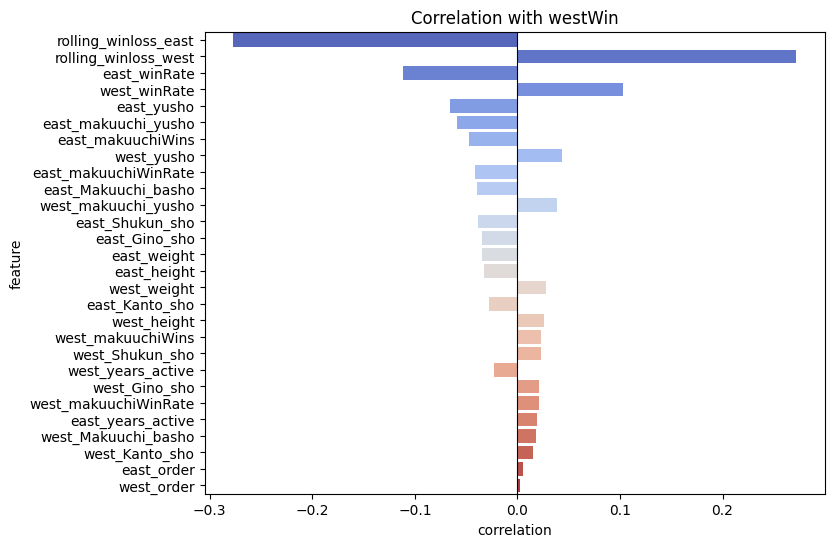

In [ ]:
numeric_cols = [f.name for f in main.schema.fields if isinstance(f.dataType, NumericType)]
numeric_cols.remove("westWin")  # we’ll treat westWin as the target

correlations = []
for col in numeric_cols:
    corr_val = main.stat.corr("westWin", col)
    correlations.append((col, corr_val))

from math import fabs
correlations = sorted(correlations, key=lambda x: fabs(x[1]), reverse=True)
corr_df = pd.DataFrame(correlations, columns=["feature", "correlation"])

plt.figure(figsize=(8, 6))
sns.barplot(data=corr_df, x="correlation", y="feature", palette="coolwarm")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Correlation with westWin")
plt.show()

# MACHINE LEARNING

In [154]:
main.printSchema()

root
 |-- westWin: integer (nullable = true)
 |-- west_yusho: long (nullable = true)
 |-- west_makuuchiWins: long (nullable = true)
 |-- west_Makuuchi_basho: long (nullable = true)
 |-- east_yusho: long (nullable = true)
 |-- east_makuuchiWins: long (nullable = true)
 |-- east_Makuuchi_basho: long (nullable = true)
 |-- west_order: integer (nullable = true)
 |-- east_order: integer (nullable = true)
 |-- east_years_active: long (nullable = true)
 |-- west_years_active: long (nullable = true)
 |-- rolling_winloss_west: double (nullable = false)
 |-- rolling_winloss_east: double (nullable = false)
 |-- west_winRate: double (nullable = false)
 |-- east_winRate: double (nullable = false)
 |-- west_makuuchiWinRate: double (nullable = false)
 |-- east_makuuchiWinRate: double (nullable = false)
 |-- height_difference: double (nullable = false)
 |-- weight_difference: double (nullable = false)
 |-- west_kimarite_entropy: double (nullable = false)
 |-- east_kimarite_entropy: double (nullable = 

AUC:  0.6168
AUPR: 0.6084
ACC:  0.5806
+----------+-------+-----+
|prediction|westWin|count|
+----------+-------+-----+
|       0.0|      0|42392|
|       0.0|      1|30295|
|       1.0|      0|31557|
|       1.0|      1|43232|
+----------+-------+-----+



In [27]:
feature_cols = [
    "west_yusho",
    "west_makuuchiWins", "west_Makuuchi_basho",
    "east_yusho", "east_makuuchiWins",
    "east_Makuuchi_basho", "west_order", "east_order", "east_years_active",
    "west_years_active", "rolling_winloss_west", "rolling_winloss_east",
    "west_winRate", "east_winRate", "west_makuuchiWinRate",
    "east_makuuchiWinRate", "height_difference", "weight_difference", "west_kimarite_entropy", "east_kimarite_entropy", "west_specialist_oshi",
    "east_specialist_oshi", "west_specialist_yotsu", "east_specialist_yotsu", "west_specialist_other", "east_specialist_other", "west_winrate_vs_opponent_specialist",
    "east_winrate_vs_opponent_specialist"
]

In [28]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline


assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="raw_features"
)

scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withMean=True,   # center to mean 0
    withStd=True     # scale to unit variance
)

lr = LogisticRegression(
    featuresCol="features",
    labelCol="westWin",
    predictionCol="prediction",
    probabilityCol="probability"
)

pipeline = Pipeline(stages=[assembler, scaler, lr])

In [61]:
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 1.0])       # try different strengths
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) # ridge, elasticnet, lasso
    .addGrid(lr.maxIter, [50, 100])               # more iterations
    .build()
)
evaluator = BinaryClassificationEvaluator(
    labelCol="westWin",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2  # use 2 cores in parallel if available
)

In [62]:
train, test = main.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()

cv_model = cv.fit(train)

# Best model
best_model = cv_model.bestModel

In [33]:
predictions = best_model.transform(test)
auc = evaluator.evaluate(predictions)
print("Test AUC:", auc)

accuracy = predictions.filter(predictions.westWin == predictions.prediction).count() / float(test.count())
print("Test Accuracy:", accuracy)

Test AUC: 0.7536857979667799
Test Accuracy: 0.6845769053493479


In [63]:
predictions = best_model.transform(test)
auc = evaluator.evaluate(predictions)
print("Test AUC:", auc)
accuracy = predictions.filter(predictions.westWin == predictions.prediction).count() / float(test.count())
print("Test Accuracy:", accuracy)

Test AUC: 0.7533406002397924
Test Accuracy: 0.6834110565843342


C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_27156\1435396052.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(20), x="coefficient", y="feature", palette="coolwarm")


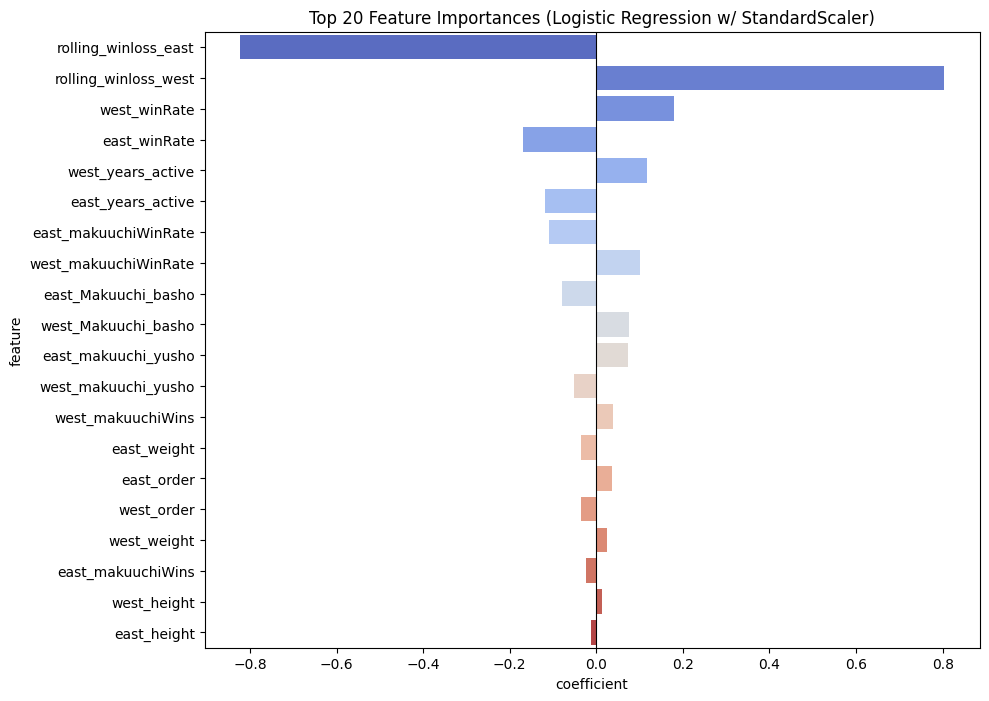

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

best_lr_model = cv_model.bestModel.stages[-1]  # LogisticRegressionModel

coef = best_lr_model.coefficients.toArray()
coef_df = pd.DataFrame({"feature": feature_cols, "coefficient": coef})
coef_df["abs_coeff"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coeff", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=coef_df.head(20), x="coefficient", y="feature", palette="coolwarm")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Top 20 Feature Importances (Logistic Regression w/ StandardScaler)")
plt.show()


save and load model

In [75]:
from datetime import datetime


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
path = f"s3a://ryans-sumo-bucket/models/sumo_westwin_best_pipeline/logistic_regression/{timestamp}"

In [77]:
best_pipeline_model = cv_model.bestModel
best_pipeline_model.save(path)


In [78]:
from pyspark.ml import PipelineModel

loaded_best_pipeline = PipelineModel.load(path)

In [79]:
predictions = loaded_best_pipeline.transform(test)
predictions.select("westWin", "probability", "prediction").show(10, truncate=False)

+-------+----------------------------------------+----------+
|westWin|probability                             |prediction|
+-------+----------------------------------------+----------+
|0      |[0.5931467274037444,0.4068532725962556] |0.0       |
|0      |[0.3062816457243944,0.6937183542756056] |1.0       |
|0      |[0.7102630090674096,0.2897369909325904] |0.0       |
|0      |[0.7141213931516447,0.2858786068483553] |0.0       |
|0      |[0.5501504335323276,0.4498495664676724] |0.0       |
|0      |[0.8109977938297473,0.18900220617025265]|0.0       |
|0      |[0.29194496796515934,0.7080550320348407]|1.0       |
|0      |[0.6838772760834023,0.3161227239165977] |0.0       |
|0      |[0.8006780426989845,0.19932195730101554]|0.0       |
|0      |[0.8520957692490413,0.1479042307509587] |0.0       |
+-------+----------------------------------------+----------+
only showing top 10 rows


In [80]:
accuracy = predictions.filter(predictions.westWin == predictions.prediction).count() / float(predictions.count())
print("Quick Accuracy:", accuracy)


Quick Accuracy: 0.6834110565843342


In [26]:
from pyspark.sql import Row

# Example new match (fill in with realistic values)
new_match = Row(
    west_height=185.0, west_weight=150.0, west_yusho=2, west_makuuchi_yusho=1,
    west_makuuchiWins=120, west_Makuuchi_basho=20, west_Gino_sho=0,
    west_Kanto_sho=1, west_Shukun_sho=0, east_height=190.0, east_weight=160.0,
    east_yusho=1, east_makuuchi_yusho=0, east_makuuchiWins=85,
    east_Makuuchi_basho=15, east_Gino_sho=0, east_Kanto_sho=0, east_Shukun_sho=0,
    west_order=5, east_order=7, east_years_active=6, west_years_active=8,
    rolling_winloss_west=0.62, rolling_winloss_east=0.55,
    west_winRate=0.65, east_winRate=0.60,
    west_makuuchiWinRate=0.61, east_makuuchiWinRate=0.59
)

new_df = spark.createDataFrame([new_match])

# Predict
result = loaded_best_pipeline.transform(new_df)
result.select("probability", "prediction").show(truncate=False)


NameError: name 'loaded_best_pipeline' is not defined

In [27]:
import pyspark
print(pyspark.__file__)


c:\Users\Ryan Jewik\Desktop\sumo_app\venv\lib\site-packages\pyspark\__init__.py


In [29]:
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define XGBoost model
xgb = SparkXGBClassifier(
    features_col="features",
    label_col="westWin",
    prediction_col="prediction",
    probability_col="probability",
    eval_metric="auc",
    max_depth=6,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    num_workers=8,
    missing = -999.0
)

# Build pipeline
pipeline = Pipeline(stages=[assembler, xgb])


In [30]:
paramGrid = (
    ParamGridBuilder()
      .addGrid(xgb.max_depth, [4, 6, 8])
      .addGrid(xgb.learning_rate, [0.05, 0.1, 0.2])
      .addGrid(xgb.subsample, [0.8, 1.0])
      .addGrid(xgb.colsample_bytree, [0.8, 1.0])
      .build()
)

evaluator = BinaryClassificationEvaluator(
    labelCol="westWin",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,      # consider 3 folds locally; XGB can be heavy
    parallelism=2
)

train, test = main.randomSplit([0.8, 0.2], seed=42)
cv_model = cv.fit(train)
preds = cv_model.transform(test)




25/09/30 20:15:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2025-09-30 20:15:58,376 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 8 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'objective': 'binary:logistic', 'subsample': 0.8, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': -999.0}
2025-09-30 20:15:58,379 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 8 workers with
	booster params: {'colsample_bytree': 1.0, 'device': 'cpu', 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'objective': 'binary:logistic', 'subsample': 0.8, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'mis

In [31]:
print("AUC:", evaluator.evaluate(preds))
acc = preds.filter(preds.westWin == preds.prediction).count() / float(preds.count())
print("Accuracy:", acc)

2025-09-30 20:40:00,049 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

AUC: 0.7861048285840342


2025-09-30 20:40:16,330 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
[Stage 3356:==================================================>   (13 + 1) / 14]

Accuracy: 0.7040913157823387


In [32]:
from pyspark.sql import functions as F

PRED_DF = preds  # <- replace with your DF that has ground truth + predictions
LABEL_COL = "westWin"        # ground-truth: 1 = west won, 0 = east won
PRED_COL  = "prediction"     # model prediction in {0,1}

# Confusion matrix table (pivoted)
cm = (
    PRED_DF
    .select(F.col(LABEL_COL).cast("int").alias("y"),
            F.col(PRED_COL).cast("int").alias("yhat"))
    .groupBy("y","yhat").count()
    .groupBy("y")
    .pivot("yhat", [0,1])  # columns: pred=0, pred=1
    .sum("count")
    .na.fill(0)
    .orderBy("y")
)
# cm schema: y, 0, 1  (rows: actual 0 then 1; cols: pred 0, pred 1)

# Pull named cells: TN, FP, FN, TP
cells = (
    PRED_DF.select(
        F.sum(F.when((F.col(LABEL_COL)==0) & (F.col(PRED_COL)==0), 1).otherwise(0)).alias("TN"),
        F.sum(F.when((F.col(LABEL_COL)==0) & (F.col(PRED_COL)==1), 1).otherwise(0)).alias("FP"),
        F.sum(F.when((F.col(LABEL_COL)==1) & (F.col(PRED_COL)==0), 1).otherwise(0)).alias("FN"),
        F.sum(F.when((F.col(LABEL_COL)==1) & (F.col(PRED_COL)==1), 1).otherwise(0)).alias("TP"),
    )
)

metrics = (
    cells.select(
        "TP","FP","FN","TN",
        ((F.col("TP")+F.col("TN")) / (F.col("TP")+F.col("TN")+F.col("FP")+F.col("FN"))).alias("accuracy"),
        (F.col("TP") / F.when((F.col("TP")+F.col("FP"))>0, F.col("TP")+F.col("FP")).otherwise(None)).alias("precision_pos"),
        (F.col("TP") / F.when((F.col("TP")+F.col("FN"))>0, F.col("TP")+F.col("FN")).otherwise(None)).alias("recall_pos"),
        (F.col("TN") / F.when((F.col("TN")+F.col("FP"))>0, F.col("TN")+F.col("FP")).otherwise(None)).alias("specificity"),
        (2*F.col("TP") / F.when((2*F.col("TP")+F.col("FP")+F.col("FN"))>0, 2*F.col("TP")+F.col("FP")+F.col("FN")).otherwise(None)).alias("f1_pos"),
    )
)

# Show
cm.show(truncate=False)
metrics.show(truncate=False)


2025-09-30 20:40:50,024 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

+---+-----+-----+
|y  |0    |1    |
+---+-----+-----+
|0  |52360|21556|
|1  |22100|51516|
+---+-----+-----+



2025-09-30 20:41:07,527 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
[Stage 3416:===============>                                      (4 + 10) / 14]

+-----+-----+-----+-----+------------------+------------------+------------------+------------------+------------------+
|TP   |FP   |FN   |TN   |accuracy          |precision_pos     |recall_pos        |specificity       |f1_pos            |
+-----+-----+-----+-----+------------------+------------------+------------------+------------------+------------------+
|51516|21556|22100|52360|0.7040913157823387|0.7050032844317933|0.6997935231471419|0.7083716651333947|0.7023887434554974|
+-----+-----+-----+-----+------------------+------------------+------------------+------------------+------------------+



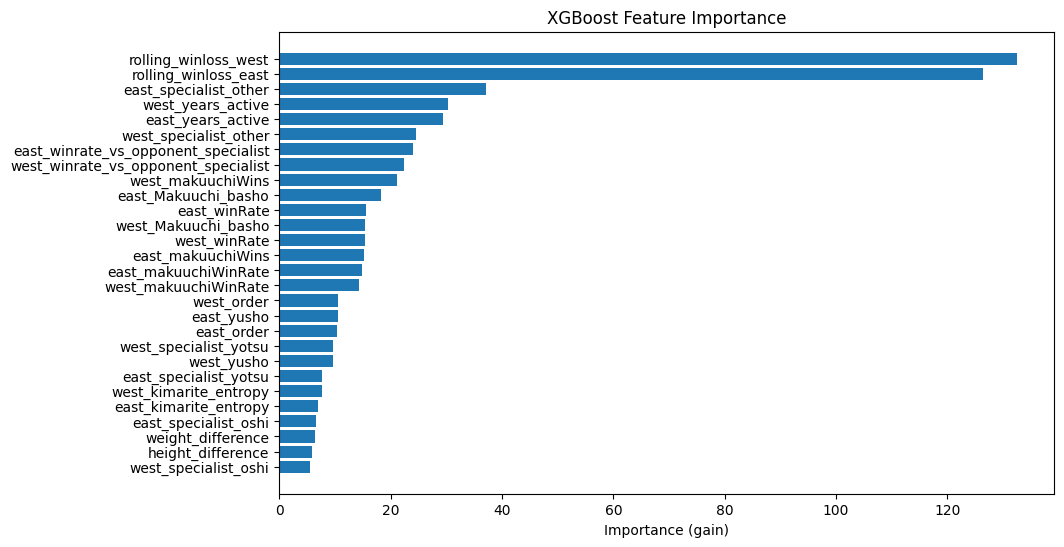

In [33]:
best_xgb = cv_model.bestModel.stages[-1]  # SparkXGBClassifierModel

# Print all params as a dict
#print(best_xgb.extractParamMap())

# Get the underlying XGBoost booster object
booster = best_xgb.get_booster()
booster.feature_names = feature_cols  # your input features
imp = booster.get_score(importance_type="gain")

imp_df = (
    pd.DataFrame(list(imp.items()), columns=["feature", "importance"])
      .sort_values("importance", ascending=False)
)

plt.figure(figsize=(10,6))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance (gain)")
plt.title("XGBoost Feature Importance")
plt.show()

In [37]:
from datetime import datetime


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
path = f"s3a://ryans-sumo-bucket/models/sumo_westwin_best_pipeline/xgboost_tree/{timestamp}"

In [38]:
best_pipeline_model = cv_model.bestModel
best_pipeline_model.save(path)


25/09/30 20:44:04 WARN TaskSetManager: Stage 3434 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

In [39]:
from pyspark.ml import PipelineModel

loaded_best_pipeline = PipelineModel.load(path)

In [40]:
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, DoubleType
from pyspark.sql import Row

# --- 1) Schema (matches yours exactly) ---
schema = StructType([
    StructField("westWin", IntegerType(), True),
    StructField("west_yusho", LongType(), True),
    StructField("west_makuuchiWins", LongType(), True),
    StructField("west_Makuuchi_basho", LongType(), True),
    StructField("east_yusho", LongType(), True),
    StructField("east_makuuchiWins", LongType(), True),
    StructField("east_Makuuchi_basho", LongType(), True),
    StructField("west_order", IntegerType(), True),
    StructField("east_order", IntegerType(), True),
    StructField("east_years_active", LongType(), True),
    StructField("west_years_active", LongType(), True),
    StructField("rolling_winloss_west", DoubleType(), False),
    StructField("rolling_winloss_east", DoubleType(), False),
    StructField("west_winRate", DoubleType(), False),
    StructField("east_winRate", DoubleType(), False),
    StructField("west_makuuchiWinRate", DoubleType(), False),
    StructField("east_makuuchiWinRate", DoubleType(), False),
    StructField("height_difference", DoubleType(), False),
    StructField("weight_difference", DoubleType(), False),
    StructField("west_kimarite_entropy", DoubleType(), False),
    StructField("east_kimarite_entropy", DoubleType(), False),
    StructField("west_specialist_oshi", IntegerType(), True),
    StructField("west_specialist_yotsu", IntegerType(), True),
    StructField("west_specialist_other", IntegerType(), True),
    StructField("east_specialist_oshi", IntegerType(), True),
    StructField("east_specialist_yotsu", IntegerType(), True),
    StructField("east_specialist_other", IntegerType(), True),
    StructField("west_winrate_vs_opponent_specialist", DoubleType(), False),
    StructField("east_winrate_vs_opponent_specialist", DoubleType(), False),
])

# --- 2) Sample rows (plausible values; adjust as needed) ---
# Notes:
# - Rates are 0..1
# - Entropy ~ [0, ln(3)≈1.098]; lower = more specialized
# - One-hot specialist flags are mutually exclusive (one of them = 1)
rows = [
    # Row 1: West is oshi specialist vs East yotsu; west slightly higher form & heavier
    Row( # westWin label kept just for reference; not required for transform
        1, 1, 120, 40,   0, 60, 30,   2, 3,   6, 7,
        0.62, 0.55, 0.68, 0.59, 0.65, 0.58,
        0.04, 12.0,   0.15, 0.70,
        1, 0, 0,   0, 1, 0,
        0.61, 0.48
    ),
    # Row 2: West yotsu vs East oshi; east a bit taller, west in good form
    Row(
        0, 0, 80, 35,   0, 95, 50,   4, 1,   10, 9,
        0.58, 0.63, 0.60, 0.66, 0.57, 0.64,
        -0.03, -6.0,   0.40, 0.20,
        0, 1, 0,   1, 0, 0,
        0.55, 0.52
    ),
    # Row 3: Both “other” specialists; quite balanced match-up
    Row(
        1, 0, 45, 20,   0, 48, 18,   5, 6,   4, 4,
        0.52, 0.50, 0.54, 0.51, 0.50, 0.49,
        0.00, 2.0,   0.95, 0.90,
        0, 0, 1,   0, 0, 1,
        0.51, 0.50
    ),
    # Row 4: West oshi vs East yotsu; east is veteran with high winrate
    Row(
        0, 0, 70, 28,   2, 140, 60,   3, 2,   14, 8,
        0.56, 0.69, 0.57, 0.72, 0.55, 0.71,
        -0.02, -8.0,   0.30, 0.25,
        1, 0, 0,   0, 1, 0,
        0.47, 0.60
    ),
    # Row 5: West yotsu vs East other; west taller/heavier, strong makuuchi record
    Row(
        1, 1, 150, 55,   0, 40, 22,   1, 7,   3, 5,
        0.70, 0.45, 0.73, 0.47, 0.72, 0.46,
        0.06, 18.0,   0.20, 0.95,
        0, 1, 0,   0, 0, 1,
        0.64, 0.49
    ),
]

sample = spark.createDataFrame(rows, schema=schema)

# --- 3) Run predictions ---
preds = loaded_best_pipeline.transform(sample)

# Inspect outputs
preds.select(
    "prediction", "probability", "rawPrediction",
    "west_winRate", "east_winRate",
    "west_winrate_vs_opponent_specialist", "east_winrate_vs_opponent_specialist"
).show(truncate=False)


2025-09-30 20:44:43,671 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
[Stage 3443:=========================>                             (5 + 6) / 11]

+----------+----------------------------------------+----------------------------------------+------------+------------+-----------------------------------+-----------------------------------+
|prediction|probability                             |rawPrediction                           |west_winRate|east_winRate|west_winrate_vs_opponent_specialist|east_winrate_vs_opponent_specialist|
+----------+----------------------------------------+----------------------------------------+------------+------------+-----------------------------------+-----------------------------------+
|1.0       |[0.4046298861503601,0.5953701138496399] |[-0.386210560798645,0.386210560798645]  |0.68        |0.59        |0.61                               |0.48                               |
|0.0       |[0.7272418737411499,0.2727580964565277] |[0.9806737899780273,-0.9806737899780273]|0.6         |0.66        |0.55                               |0.52                               |
|0.0       |[0.554901123046875,0.44